In [1]:
from img_cap_lib import *
# imports
import torch
import torchvision
import torchtext
from torchtext.vocab import vocab, GloVe, Vectors
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import os
from PIL import Image
import string
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
import pickle
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import nltk

/Users/ronnyschneeberger/Documents/FHNW/HS22/del-image-captioning/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Daten herunterladen

In [2]:
data_download("flickr8k")

Data already exi sts at flickr8k


# Modell ohne Normalisierung

## Modell laden

In [34]:
# load model
model_stats = torch.load("models/temp_model.pt", map_location=torch.device('cpu'))
model = load_captioning_model(model_stats)

## Preprocessing

In [13]:
# caption preprocessing
embedding_dim = 300
min_frequency = 1

captions = pd.read_csv("flickr8k/captions.txt")
caption_preprocessor = CaptionPreprocessor(embedding=model_stats['embedding'].embedding_matrix, vocabulary=model_stats['embedding'].vocabulary ,captions=captions, embedding_dim=embedding_dim, min_frequency=min_frequency)
caption_preprocessor.preprocess()

# image preprocessing
img_preprocessor = ImagePreprocessor(normalize=False, image_folder_path="flickr8k")
img_preprocessor.preprocess_images()

Shape captions: (40460, 2)


/Users/ronnyschneeberger/Documents/FHNW/HS22/del-image-captioning/img_cap_lib.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.captions.caption = self.captions.caption.apply(lambda x: x.strip("."))


Shape captions after filtering: (39749, 3)
Removed Captions:  711 , in Percent:  1.76
transformed_images folder already exists. No preprocessing necessary.


## Datensplit und DataLoader

In [35]:
# create split
training_data, test_data = train_test_split(caption_preprocessor.captions, test_size=0.15, random_state=42)

# create datasets
train_dataset = FlickrDataset(captions=training_data, embedding=model.embedding)
test_dataset = FlickrDataset(captions=test_data, embedding=model.embedding)

# create dataloaders
batch_size = 8
train_loader = FlickrLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = FlickrLoader(test_dataset, batch_size=4, shuffle=False, drop_last=True)

In [36]:
class Evaluator:
    def __init__(self, model, dataloader, device):
        # initiate variables 
        self.model = model
        self.dataloader = dataloader
        self.device = device
        # self.model.eval()
        # assert self.dataloader.batch_size == 1, "Batch size must be 1 for evaluation."
    
    def evaluate(self):
        scores = []

        for i, (images, captions, lengths, vectorized_captions) in enumerate(self.dataloader):
            # move to device
            images = images.to(self.device)
            captions = captions.to(self.device)
            vectorized_captions = vectorized_captions.to(self.device)
            
            # forward pass
            output = self.model.forward(images)
            references = self.model.words[vectorized_captions.cpu()]

            for j in range(output.shape[0]):
                candidate = self.output_to_sentence(output[j,:])
                reference = self.output_to_sentence(references[j,:])
                scores.append(self.bleu_score(candidate, reference))
            
            print(f"Batch: {i+1} of {len(self.dataloader)}")

        print(f"Average BLEU score: {np.mean(scores)}")
        return np.mean(scores), scores

    @staticmethod
    def output_to_sentence(output:list):
        '''
        Removes Tokens from model output.
        '''
        output = [token for token in output if token not in ["<SOS>", "<EOS>", "<PAD>"]]
        return output

    @staticmethod
    def bleu_score(reference, candidate):
        '''
        Calculates the BLEU score for a single reference and candidate. Uses the SmoothingFunction for smoothing when no overlap between certain n-grams is found. 

        Params:
        -------
        reference: list of strings - The reference sentence.
        candidate: list of strings - The candidate sentence.

        Returns:
        --------
        bleu_score: float - The BLEU score.
        '''
        # calculate the BLEU score
        return nltk.translate.bleu_score.sentence_bleu(reference, candidate, smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)

In [37]:
# train_evaluator = Evaluator(model, train_loader, device)
test_evaluator = Evaluator(model, test_loader, device)

# train_bleu, train_scores = train_evaluator.evaluate()
test_bleu, test_scores = test_evaluator.evaluate()

# print(f"Train BLEU: {train_bleu}")
print(f"Test BLEU: {test_bleu}")

Batch: 1 of 1490
Batch: 2 of 1490
Batch: 3 of 1490
Batch: 4 of 1490
Batch: 5 of 1490
Batch: 6 of 1490
Batch: 7 of 1490
Batch: 8 of 1490
Batch: 9 of 1490
Batch: 10 of 1490
Batch: 11 of 1490
Batch: 12 of 1490
Batch: 13 of 1490


KeyboardInterrupt: 

In [38]:
batch = next(iter(train_loader))
batch_test = next(iter(test_loader))

In [39]:
def plot_test_captions(model, batch):
    '''prints images, captions and predicted captions from a batch'''

    caption_from_dataset = model.embedding.index_to_caption(batch[3].permute(1,0))
    predicted_captions = model.forward(batch[0])

    for i, img in enumerate(batch[0]):
        plt.imshow(img.long().permute(1, 2, 0))
        plt.show()
        predicted_caption = " ".join(predicted_captions[i])
        predicted_caption = predicted_caption.split('<EOS>')[0]
        predicted_caption = predicted_caption.lstrip('<SOS>')
        print("predicted")
        print(20*"-")
        print(predicted_caption, "\n")
        
        caption = " ".join(caption_from_dataset[i])
        caption = caption.split('<EOS>')[0]
        caption = caption.lstrip('<SOS>')
        print("caption")
        print(20*"-")
        print(caption)


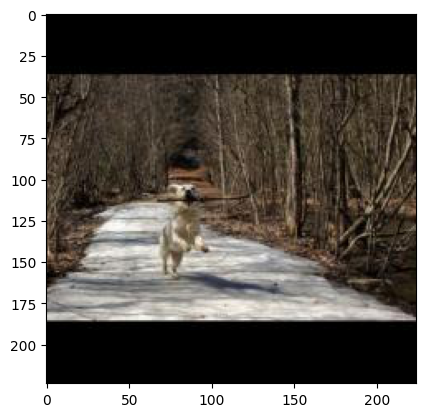

predicted
--------------------
 a person is walking in the woods  

caption
--------------------
 a dog jumps forward carrying a large stick 


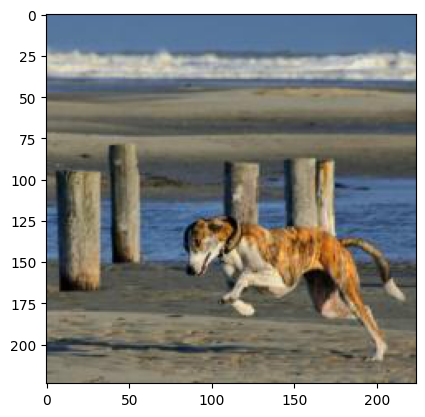

predicted
--------------------
 a dog standing on a person s legs and another dog sits on a bed  

caption
--------------------
 a tan dog runs along a beach near wood stumps 


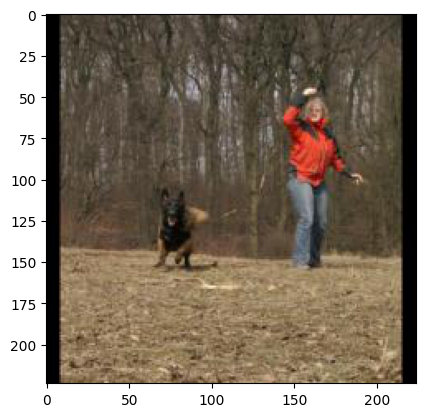

predicted
--------------------
 a young person in jeans black pants and brown hat  

caption
--------------------
 a dog is preparing to run away from a person interacting with it 


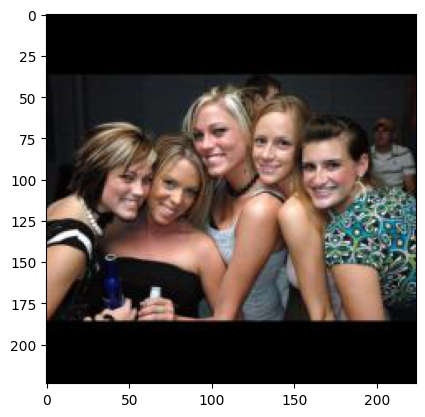

predicted
--------------------
 a man is wearing a neon yellow vest while leaning against a trashcan and by a woman in a pink shirt 

caption
--------------------
 a group of partying girls gather for a picture 


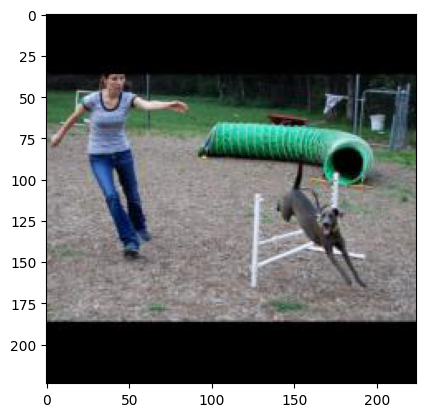

predicted
--------------------
 a girl in a pink shirt jumps from a blue slide  

caption
--------------------
 a woman running around a course with a grey dog jumping a railing 


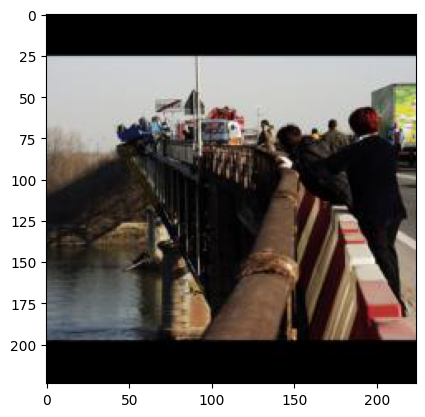

predicted
--------------------
 a group of people walk through a carnival ride  

caption
--------------------
 many people standing on a bridge over murky water 


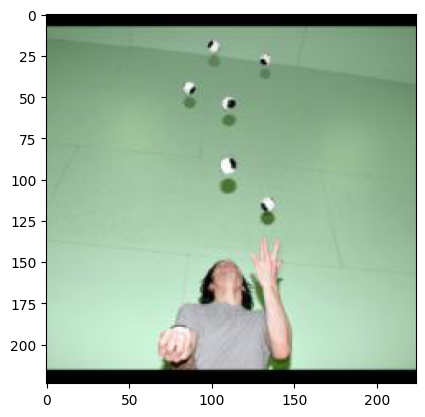

predicted
--------------------
 a dog stands in the surf next to a building  

caption
--------------------
 the man juggles six balls easily 


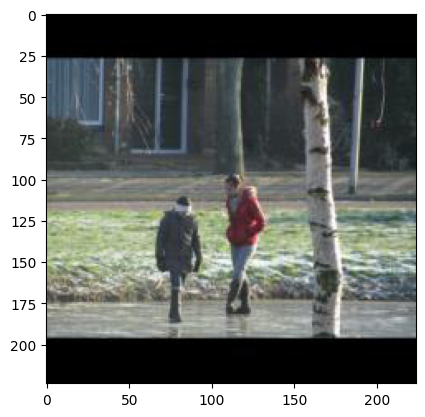

predicted
--------------------
 a girl and a boy are bending over the same big in a bucket  

caption
--------------------
 two people dressed in winter apparel venture out onto a frozen body of water 


In [40]:
plot_test_captions(model, batch)

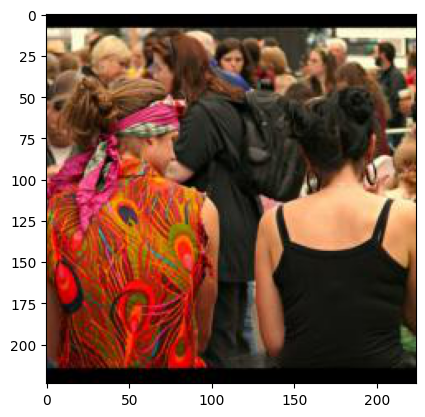

predicted
--------------------
 a girl has her head in a bucket of water while an older lady sitting on the ground  

caption
--------------------
 a large group of people doing varied activities 


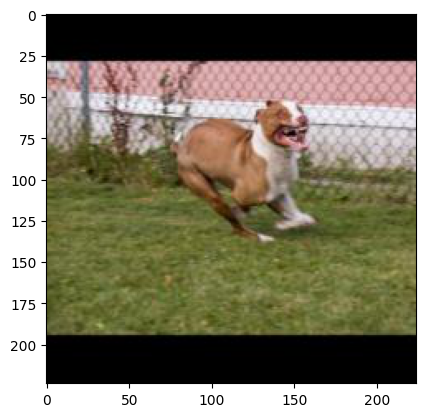

predicted
--------------------
 a person is holding up a camera while looking at a yellow case on a boat  

caption
--------------------
 a brown and white dog running crazily through the grass 


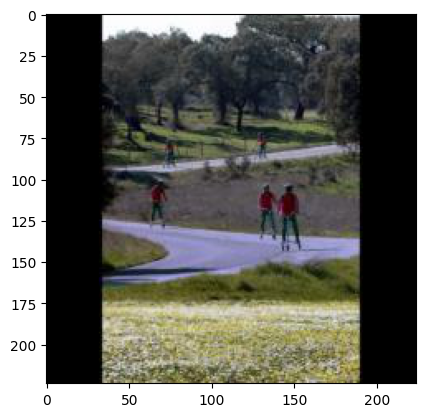

predicted
--------------------
 a person stands next to a car that is holding in its mouth  

caption
--------------------
 several people dressed alike are traveling down a curvy road on scooters 


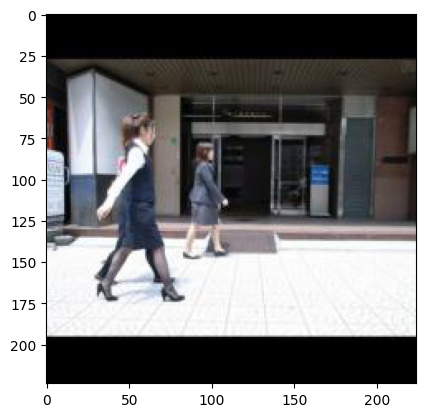

predicted
--------------------
 a dog is being squirted with water in a patch of green balls  

caption
--------------------
 business women walk outside 


In [42]:
plot_test_captions(model, batch_test)

# Modell mit Normalisierung

In [44]:
model_stats = torch.load("models/with_normalisation.pt", map_location=torch.device('cpu'))
model = load_captioning_model(model_stats)

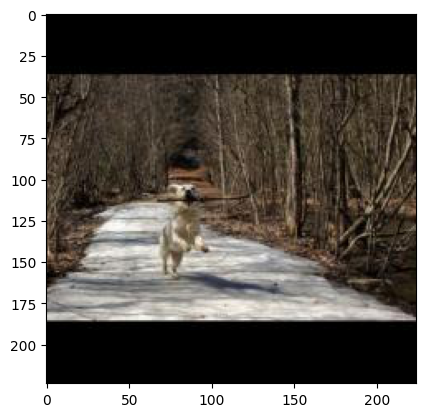

predicted
--------------------
 a dog running through a fence in a park in the park with trees in the background  

caption
--------------------
 a dog jumps forward carrying a large stick 


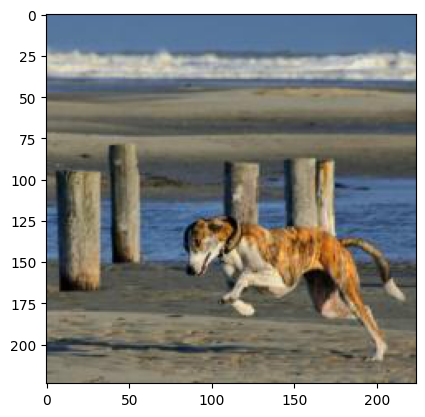

predicted
--------------------
 a tan dog runs on the grass near a wooden fence and dry grass to his mouth  

caption
--------------------
 a tan dog runs along a beach near wood stumps 


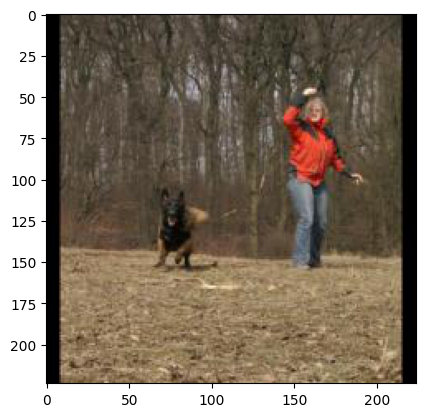

predicted
--------------------
 two women one with a brown dog are running  

caption
--------------------
 a dog is preparing to run away from a person interacting with it 


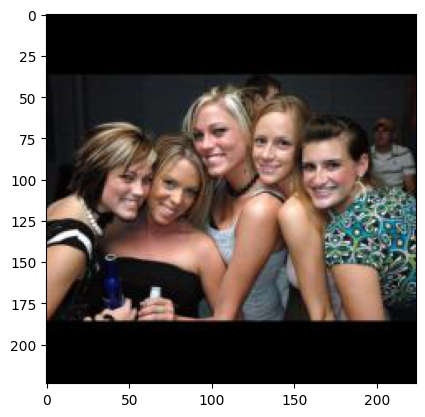

predicted
--------------------
 a group of young girls smile each other in the all all a pink blanket in a book  

caption
--------------------
 a group of partying girls gather for a picture 


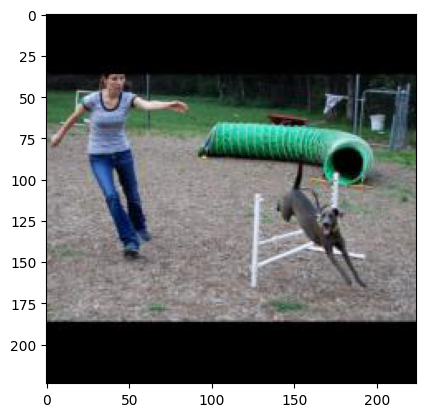

predicted
--------------------
 a woman playing with a dog over a fence to fetch in the distance  

caption
--------------------
 a woman running around a course with a grey dog jumping a railing 


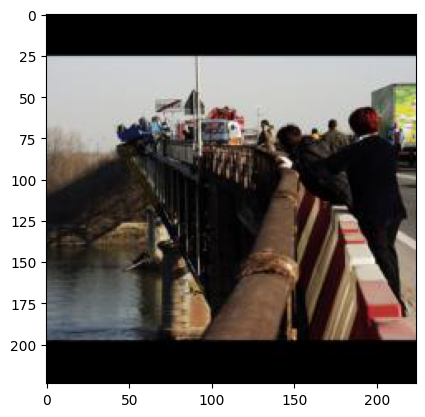

predicted
--------------------
 a group of people are staring in a snowy setting at night sky that ski covered in the street  

caption
--------------------
 many people standing on a bridge over murky water 


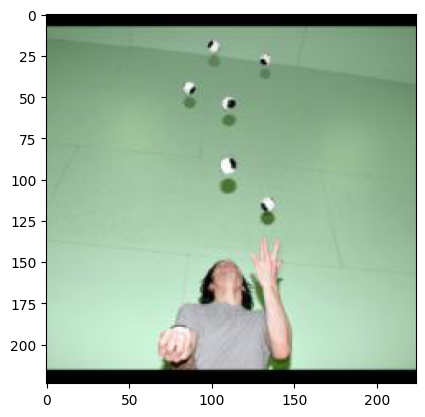

predicted
--------------------
 a man in a black shirt and white shorts holding a large yellow ball to hit bubbles about to throw a 

caption
--------------------
 the man juggles six balls easily 


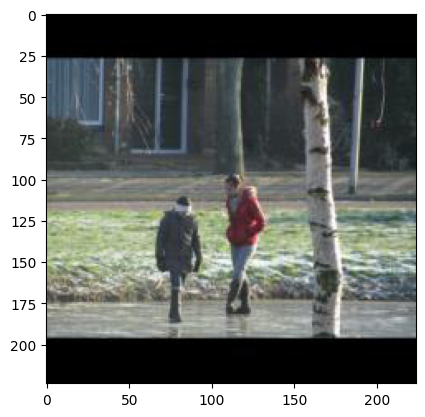

predicted
--------------------
 two children in a small tan are walking through the grass close to a hill by the woods  

caption
--------------------
 two people dressed in winter apparel venture out onto a frozen body of water 


In [45]:
plot_test_captions(model, batch)

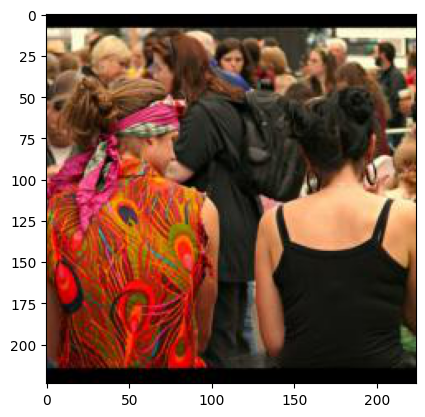

predicted
--------------------
 a woman in a colorful dress is sitting to wait to wait in an artist s pizza sitting from behind her 

caption
--------------------
 a large group of people doing varied activities 


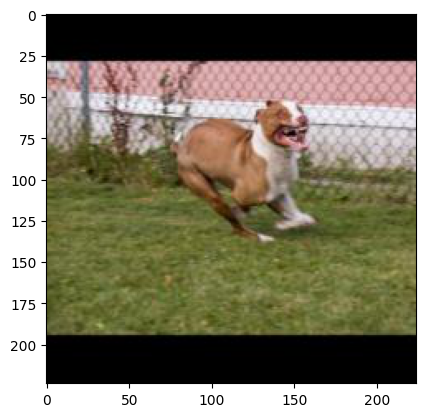

predicted
--------------------
 a dog running on a lawn in a field of dry grass  

caption
--------------------
 a brown and white dog running crazily through the grass 


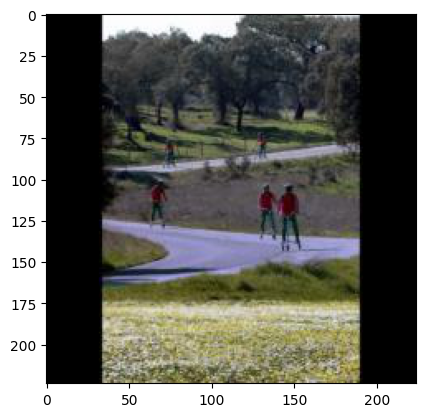

predicted
--------------------
 a person in a brown jacket and pink shorts riding a bike through two lane  

caption
--------------------
 several people dressed alike are traveling down a curvy road on scooters 


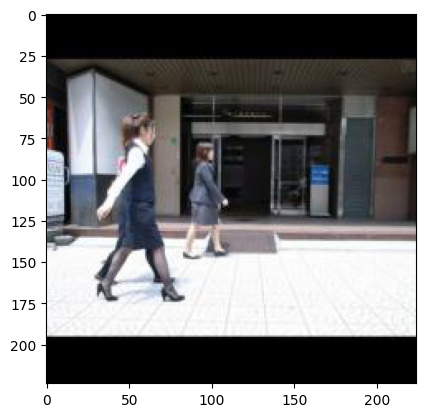

predicted
--------------------
 two young girls are performing in a park with a white urban behind them and a street  

caption
--------------------
 business women walk outside 


In [46]:
plot_test_captions(model, batch_test)